In [1]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

/opt/conda/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: 100%|██████████| 4.09k/4.09k [00:00<00:00, 2.91MB/s]
Downloading: 100%|██████████| 577M/577M [00:11<00:00, 50.7MB/s] 
Downloading: 100%|██████████| 568/568 [00:00<00:00, 396kB/s]
Downloading: 100%|██████████| 842k/842k [00:08<00:00, 106kB/s]  
Downloading: 100%|██████████| 512k/512k [00:04<00:00, 130kB/s]  
Downloading: 100%|██████████| 2.12M/2.12M [00:15<00:00, 146kB/s] 
Downloading: 100%|██████████| 389/389 [00:00<00:00, 170kB/s]


In [18]:
print(outputs.keys())
print(outputs.vision_model_output.keys())
print(outputs.text_model_output.keys())

odict_keys(['last_hidden_state', 'pooler_output'])
odict_keys(['last_hidden_state', 'pooler_output'])


In [16]:
print(outputs.vision_model_output.last_hidden_state.shape)
print(outputs.vision_model_output.pooler_output.shape)
print(outputs.text_model_output.last_hidden_state.shape)
print(outputs.text_model_output.pooler_output.shape)


torch.Size([1, 50, 768])
torch.Size([1, 768])
torch.Size([2, 7, 512])
torch.Size([2, 512])


In [3]:
import numpy as np
import os
dirs = "/home/jhshin4727/data/ImageNet-LT-text/train"
for folder in os.listdir(dirs):
    datas = os.listdir(os.path.join(dirs, folder))
    for data in datas:
        if "npy" in data:
            tmp = np.load(os.path.join(dirs, folder, data))
            if tmp.shape[0] == 0:
                print(f"0 samples in {tmp}")
            else:
                print(f"{tmp.shape[0]}")

1250
1050
784
948
1157
1208
1253
1255
1150
1250
1266
1245
1275
1265
1179
1293
1068
1287
908
1143
1213
1119
1123
1129
1186
1244
1166
1244
1021
1052
1013
1217
1235
1244
1182
1257
1232
1261
1286
1204
1220
1285
1064
1197
1236
1246
954
1268
1099
1271
924
1273
1111
1204
1231
1143
1284
1127
1295
1266
1266
1150
1243
1222
1269
1292
1256
1003
951
1228
1265
1264
872
1290
1163
1242
1220
1256
1270
1285
1174
1207
1266
1165
1074
1019
20
1281
1262
798
1114
1219
1239
1078
1285


In [13]:
img = "train/n01440764/n01440764_190.JPEG"
count=1000
image_name = f"{img[:img.rfind('/')]}/real_{count:04d}.JPEG"
print(image_name)

train/n01440764/real_1000.JPEG


In [15]:
import os
import shutil
from tqdm import tqdm

imagenet_stats = dict()      
real_images = 0
with open("ImageNet-LT/ImageNet_labels.txt", "r") as f:
    lines = f.read().splitlines()
    cls_ids, cls_idxs, cls_names = zip(*[i.split(" ") for i in lines])
    for cls_id, cls_idx, cls_name in zip(cls_ids, cls_idxs, cls_names):
        sample_dict = dict()
        sample_dict['name'] = cls_name
        sample_dict['id'] = cls_id
        sample_dict['idx'] = cls_idx
        sample_dict['num'] = 0
        sample_dict['prompt'] = f"a realistic image of {cls_name.replace('_', ' ')}"
        imagenet_stats[cls_idx] = sample_dict
        os.makedirs(os.path.join(f"/root/data/data/ImageNet-LT", "train", f"{cls_id}"), exist_ok=True)

with open("ImageNet-LT/ImageNet_LT_train.txt", "r") as f:
    lines = f.read().splitlines()
    subset_image_list, subset_label_list = zip(*[i.split(" ") for i in lines])
    count = 0
    prev_label = 0
    for img, label in tqdm(zip(subset_image_list, subset_label_list)):
        imagenet_stats[label]['num'] += 1
        real_images += 1
        if prev_label != label:
            count = 0
            prev_label = label
        new_name = f"{img[:img.rfind('/')]}/real_{label}_{count:04d}.JPEG"
        shutil.copy(os.path.join(f"/root/data2/data/ImageNet", img), os.path.join(f"/root/data/data/ImageNet-LT", new_name))
        count += 1

115846it [12:53, 149.86it/s]


In [30]:
per_gpu_samples = [1,2,3,4]
per_gpu_samples[-1]=10
per_gpu_samples

[1, 2, 3, 10]

1280
5
115.846


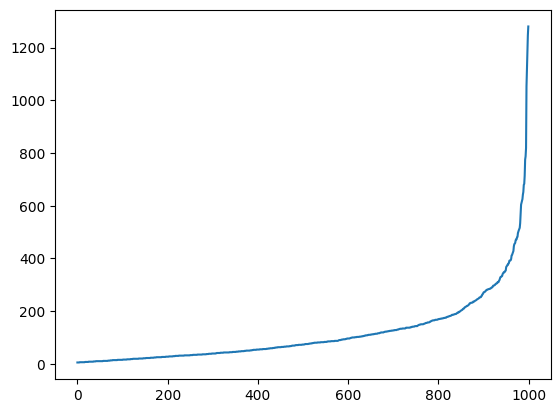

In [46]:
import matplotlib.pyplot as plt
import numpy as np

nums = []
for i in imagenet_stats:
    nums.append(imagenet_stats[i]['num'])
print(np.max(nums))
print(np.min(nums))
print(np.mean(nums))
plt.plot(sorted(nums))